In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

tf.random.set_seed(47)
tfd = tfp.distributions

In [2]:
# 가우스 분포
tfd.Normal(loc=0.,scale=1.)

2022-05-25 06:35:40.944749: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-25 06:35:41.247961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22295 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [3]:
def Dist(dst):
    sns.distplot(dst.sample(1000))
    plt.plot()

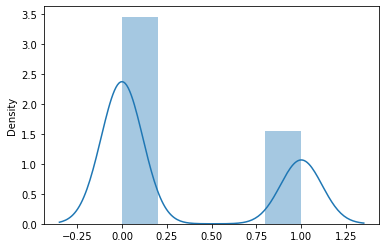

In [4]:
Dist(dst = tfd.Bernoulli(probs=0.3))

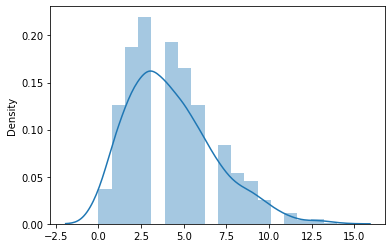

In [5]:
Dist(dst = tfd.NegativeBinomial(total_count=10,probs=0.3))

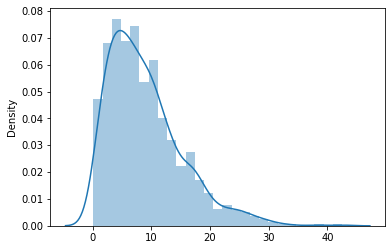

In [6]:
Dist(dst = tfd.Weibull(concentration=1.5,scale=10))

In [7]:
tfd.Normal(loc=[-1.,0.5], scale=[1.,1.5]) # batch_shaep : 분포의 개수 - univariate 2개

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [8]:
tfd.MultivariateNormalDiag(loc=[-1.,0.5], scale_diag=[1.,1.5]) # event_shape : 차원 - multivariate 1개

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [9]:
tfd.MultivariateNormalDiag(
    loc=[[-1.,0.5],[2.,0.],[-0.5,1.5]],
    scale_diag=[[1.,1.5],[2.,0.5],[1.,1.]])

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float32>

In [10]:
# Mean
mu = [0., 0.] 

# Covariance
scale_tril = [[1.,  0.],
              [0.6, 0.8]]
sigma = tf.matmul(tf.constant(scale_tril), tf.transpose(tf.constant(scale_tril))) # 공분산 행렬
print(sigma)

tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril) # correlation이 있는 full covariance Gaussain - dependent

tf.Tensor(
[[1.         0.60009766]
 [0.60009766 0.99980474]], shape=(2, 2), dtype=float32)


2022-05-25 06:35:42.860862: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

In [11]:
# Mean
mu = [1., 2., 3.]

# Covariance
'''
공분산 행렬은
1. symmetric
2. positive semidefinite (>=0)
'''
sigma = [[0.5, 0.1, 0.1],
         [0.1,  1., 0.6],
         [0.1, 0.6, 2.]]

scale_tril = tf.linalg.cholesky(sigma) # L*transpose(L) = M 처럼 분해
print(scale_tril)

tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)

2022-05-25 06:35:42.912573: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x71fe4a0


tf.Tensor(
[[0.7071067  0.         0.        ]
 [0.14142135 0.9899495  0.        ]
 [0.14142135 0.58588856 1.2793493 ]], shape=(3, 3), dtype=float32)


<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[3] dtype=float32>

In [12]:
# event_shape = 2
mvn = tfd.MultivariateNormalDiag(loc=[-1.,0.5],
                                 scale_diag=[1.,1.5])

# batch_shape = 2
batched_normal = tfd.Normal(loc=[-1.,0.5],
                                 scale=[1.,1.5])

In [13]:
tfd.Independent(batched_normal,reinterpreted_batch_ndims=1) # batch_shape -> event_shape : 여러 개의 단변량 분포를 독립적인 (correlation=0)인 다변량으로 바꿈

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [14]:
exponential = tfd.Exponential(rate=0.3,name='exp')

exp_train = tfd.Exponential(rate=tf.Variable(1.), name='exp_train')
exp_train.trainable_variables

2022-05-25 06:35:43.544170: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,)

In [15]:
negloglik = lambda y_true, dst: -tf.reduce_mean(dst.log_prob(y_true))

def train_step(data,dist,epochs=15):
    train_loss = []
    train_rate = []
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for epoch in range(1, epochs+1):
        with tf.GradientTape() as tape:
            tape.watch(dist.trainable_variables)
            loss = negloglik(data, dist)
            grads = tape.gradient(loss,dist.trainable_variables)
        opt.apply_gradients(zip(grads,dist.trainable_variables))
        rate=dist.rate.value()
        train_loss.append(loss)
        train_rate.append(rate)
        print('Epoch {:03d} | Loss :{:.3f} Rate:{:.3f}'.format(epoch,loss,rate))
    return train_loss, train_rate

In [16]:
train_loss, train_rate = train_step(data=exponential.sample(3000), dist=exp_train)

Epoch 001 | Loss :3.355 Rate:0.765
Epoch 002 | Loss :2.833 Rate:0.560
Epoch 003 | Loss :2.458 Rate:0.403
Epoch 004 | Loss :2.261 Rate:0.316
Epoch 005 | Loss :2.212 Rate:0.297
Epoch 006 | Loss :2.210 Rate:0.298
Epoch 007 | Loss :2.210 Rate:0.298
Epoch 008 | Loss :2.210 Rate:0.298
Epoch 009 | Loss :2.210 Rate:0.298
Epoch 010 | Loss :2.210 Rate:0.298
Epoch 011 | Loss :2.210 Rate:0.298
Epoch 012 | Loss :2.210 Rate:0.298
Epoch 013 | Loss :2.210 Rate:0.298
Epoch 014 | Loss :2.210 Rate:0.298
Epoch 015 | Loss :2.210 Rate:0.298


In [17]:
print(f"pred {exp_train.rate.numpy()}")
print(f"y_true {exponential.rate.numpy()}")

pred 0.29807502031326294
y_true 0.30000001192092896


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MeanSquaredError

tfpl = tfp.layers

In [19]:
# 1. Deterministic
determine = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1), # weight의 초기값
          bias_initializer=tf.constant_initializer(0)), # bias의 초기값
])

# 2. Probabilistic
# step 1 : 이전 layer의 output이 분포의 parameter로 들어간다
# step 2 : convert_to_tensor_fn의 값에 따라 최종 output를 낸다

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample) # sample : 확률론적, mean : 결정론적
])

In [20]:
X_train = np.linspace(-5,5,500)[:, np.newaxis]
y_train = model.predict(X_train)

In [21]:
untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
])

negloglik = lambda y_true, y_pred: -tf.reduce_sum(y_pred.log_prob(y_true))

untrained.compile(loss=negloglik, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01))

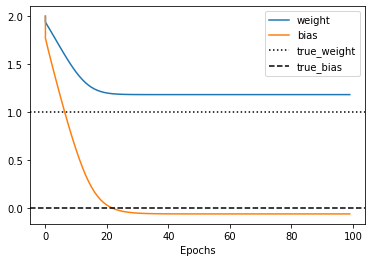

In [22]:
epochs = [0]
training_weights = [untrained.weights[0].numpy()[0, 0]]
training_bias = [untrained.weights[1].numpy()[0]]

for epoch in range(100):
    untrained.fit(X_train, y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(untrained.weights[0].numpy()[0, 0])
    training_bias.append(untrained.weights[1].numpy()[0])

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [23]:
# Layer 비교
X_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = X_train + 0.3*np.random.randn(100)[:, np.newaxis] # y = x + 0.3e (e ~ N(0,1))

# determininstic Dense layer
deter = Sequential([
    Dense(units=1, input_shape=(1,))
])

deter.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
deter.fit(X_train, y_train, epochs=100, verbose=False)

In [24]:
tfd.Independent(tfd.Normal(loc=Dense(units=1, input_shape=(1,))(X_train),scale=1))

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


<tfp.distributions.Independent 'IndependentNormal' batch_shape=[100] event_shape=[1] dtype=float32>

In [25]:
# probabilistic Dense layer - Aleatoric
'''
Uncertainty
1. Epistemic : weight가 uncertain
2. Aleatoric : data 자체의 uncertainty
'''

prob = Sequential([
    Dense(units=1, input_shape=(1,)), # Dense layer는 deterministic
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t,scale=1)))
])

prob2 = Sequential([
    Dense(units=2*1, input_shape=(1,)),
    # Dense(units=tfpl.IndependentNormal.params_size(X_train.shape[-1]), input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:]))))
])

prob.compile(loss=negloglik, optimizer=RMSprop(learning_rate=0.005))
prob.fit(X_train, y_train, epochs=100, verbose=False)

In [26]:
x = np.array([[0.]])
y_deter  = deter(x)
y_prob  = prob(x)

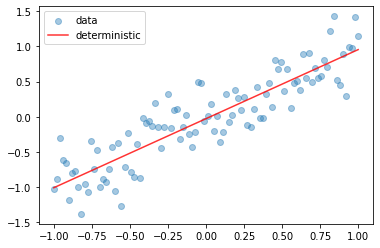

In [27]:
plt.scatter(X_train, y_train, alpha=0.4, label='data')
plt.plot(X_train, deter.predict(X_train), color='red', alpha=0.8, label='deterministic')
plt.legend()
plt.show()

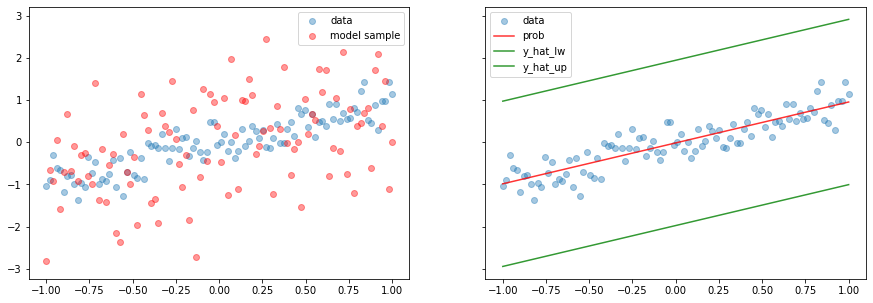

In [28]:
y_model = prob(X_train)
y_sample = prob(X_train).sample()

y_hat = y_model.mean()
y_std = y_model.stddev()
y_hat_lw = y_hat - 1.96 * y_std
y_hat_up = y_hat + 1.96 * y_std

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(X_train, y_train, alpha=0.4, label='data')
ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()

ax2.scatter(X_train, y_train, alpha=0.4, label='data')
ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='prob')
ax2.plot(X_train, y_hat_lw, color='green', alpha=0.8, label='y_hat_lw')
ax2.plot(X_train, y_hat_up, color='green', alpha=0.8, label='y_hat_up')
ax2.legend()
plt.show()

In [41]:
# Probabilistic - Epistemic
'''
1. prior : not trainable, MultivariateNormal
    - input : weight과 bias의 차원
    - output : prior model -> input에서 지정한 차원의 분포
2. posterior : trainable - 추정
    - input : weight과 bias의 차원
    - output : posterior model -> trainable한 확률론적 layer 생성 후 posterior가 따르는 분포 쌓음
'''

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t:tfd.MultivariateNormalDiag(loc=tf.zeros(n),scale_diag=tf.ones(n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [42]:
prob3 = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                         units=1,
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/X_train.shape[0],
                         kl_use_exact=True)
])

In [44]:
X_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(X_train, 3) + 0.1*(2+X_train)*np.random.randn(1000)[:, np.newaxis]

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(X_train.shape[-1]),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0]),
    tfpl.IndependentNormal(1)
])

In [45]:
model.compile(loss=negloglik, optimizer=RMSprop(learning_rate=0.005))
model.fit(X_train, y_train, epochs=100, verbose=False)
model.evaluate(X_train, y_train)

32/32 [==============================] - 0s 866us/step - loss: 13.5334


13.533395767211914

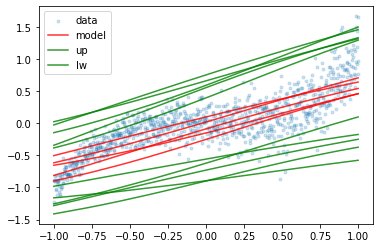

In [47]:
plt.scatter(X_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(X_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(X_train, y_hat, color='red', alpha=0.8, label='model')
        plt.plot(X_train, y_hat_m2sd, color='green', alpha=0.8, label = 'up')
        plt.plot(X_train, y_hat_p2sd, color='green', alpha=0.8, label = 'lw')
    else:
        plt.plot(X_train, y_hat, color='red', alpha=0.8)
        plt.plot(X_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(X_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

In [48]:
tfb = tfp.bijectors # 분포를 변환

In [52]:
scale=4.5
shift=7
scale_n_shift = tfb.Chain([tfb.Shift(shift),tfb.Scale(scale)])

# scale_1 = tfb.Scale(scale)
# shift_2 = tfb.Shift(shift)
# scale_n_shift = shift_2(scale_1)

In [55]:
# 분포 z를 x로 변환

normal = tfd.Normal(loc=0., scale=1.)
n = 10000
z = normal.sample(n)

x = scale_n_shift(z)
tf.norm(x-(scale*z+shift))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [56]:
inv_x = scale_n_shift.inverse(x)
tf.norm(inv_x-z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [58]:
log_prob_x = normal.log_prob(z) - scale_n_shift.forward_log_det_jacobian(z, event_ndims=0)
# log_prob_x2 = normal.log_prob(scale_n_shift.inverse(x)) + scale_n_shift.inverse_log_det_jacobian(x,event_ndims=0)

In [59]:
x = tf.random.normal(shape=(100,1))
sf = tfb.Softfloor(temperature=[0.2,0.1])
y = sf.forward(x)  # shape : (100,2)

exps = tfb.GumbelCDF(loc=[0.5,1.0,1.5,2.0,2.5,3],scale=[1,1,2,2,3,3])

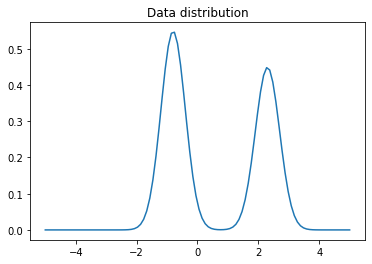

In [62]:
probs = [0.45,0.55]

mix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=probs),
    components=[
        tfd.Normal(loc=2.3,scale=0.4),
        tfd.Normal(loc=-0.8,scale=0.4)
    ])

x = np.linspace(-5.0,5.0,100)
plt.plot(x,mix_gauss.prob(x))
plt.title('Data distribution')
plt.show()